In [22]:
import pandas as pd
import numpy as np
import os
import shutil # For potentially creating structured directories if needed, though flow_from_dataframe avoids this
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
IMG_HEIGHT, IMG_WIDTH = 299, 299  # InceptionV3 default input size
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 0.001
IMAGE_DIR = '../ham-concept/ham_concept_dataset/ISIC2018_Task3_Training_Input'
TRAIN_CSV_PATH = '../ham-concept/ham_concept_dataset/Datasets/metadata/train.csv'
VAL_CSV_PATH = '../ham-concept/ham_concept_dataset/Datasets/metadata/val.csv'
MODEL_WEIGHTS_PATH = 'inceptionv3_isic2018_best.weights.h5'


In [25]:
def load_and_prepare_df(csv_path, image_dir):
    df = pd.read_csv(csv_path)
    
    df_processed = df[['image_id', 'benign_malignant']].copy()
    
    df_processed['filename'] = df_processed['image_id'].apply(lambda x: x + '.jpg')
    
    # Ensure the target column 'benign_malignant' is string type for ImageDataGenerator
    # It should contain '0' for nevus and '1' for melanoma as per the problem description.
    df_processed['benign_malignant'] = df_processed['benign_malignant'].astype(str)
    
    print(f"Loaded {csv_path}:")
    print(f"  Total rows: {len(df_processed)}")
    if not df_processed.empty:
        print(f"  Melanoma (1): {len(df_processed[df_processed['benign_malignant'] == '1'])}")
        print(f"  Nevus (0): {len(df_processed[df_processed['benign_malignant'] == '0'])}")

    return df_processed[['filename', 'benign_malignant']]

In [26]:
train_df = load_and_prepare_df(TRAIN_CSV_PATH, IMAGE_DIR)
val_df = load_and_prepare_df(VAL_CSV_PATH, IMAGE_DIR)

Loaded ../ham-concept/ham_concept_dataset/Datasets/metadata/train.csv:
  Total rows: 5198
  Melanoma (1): 1834
  Nevus (0): 3364
Loaded ../ham-concept/ham_concept_dataset/Datasets/metadata/val.csv:
  Total rows: 650
  Melanoma (1): 237
  Nevus (0): 413


In [27]:
train_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3_preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation data, only apply preprocessing
val_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3_preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='benign_malignant',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary', # Since we have 0 and 1
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='benign_malignant',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Important for evaluation
)

Found 5198 validated image filenames belonging to 2 classes.
Found 650 validated image filenames belonging to 2 classes.


In [28]:
print("Class indices from train_generator:", train_generator.class_indices)
# Expected: {'0': 0, '1': 1} where 1 is melanoma

Class indices from train_generator: {'0': 0, '1': 1}


In [29]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # Regularization
predictions = Dense(1, activation='sigmoid')(x) # Binary classification: 1 unit, sigmoid activation

model = Model(inputs=base_model.input, outputs=predictions)

# --- 4. Compile the Model ---
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,901,985 (91.18 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [30]:
checkpoint = ModelCheckpoint(MODEL_WEIGHTS_PATH,
                             monitor='val_auc', # Monitor validation AUC
                             save_best_only=True,
                             save_weights_only=True, # Save only weights
                             mode='max', # For AUC, higher is better
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_auc',
                               patience=10, # Number of epochs with no improvement
                               restore_best_weights=True, # Restore model weights from the epoch with the best value
                               mode='max',
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_auc',
                              factor=0.2, # Factor by which learning rate will be reduced
                              patience=5,
                              min_lr=1e-7, # Lower bound on the learning rate
                              mode='max',
                              verbose=1)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
    # class_weight=class_weight # Uncomment if using class weights
)

/home/nqmtien/miniconda3/envs/REIT4841_tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.6201 - auc: 0.5829 - loss: 1.0470
Epoch 1: val_auc improved from -inf to 0.78574, saving model to inceptionv3_isic2018_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 79s 439ms/step - accuracy: 0.6203 - auc: 0.5832 - loss: 1.0451 - val_accuracy: 0.7359 - val_auc: 0.7857 - val_loss: 0.5454 - learning_rate: 0.0010
Epoch 2/300
  1/162 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.7812 - auc: 0.6276 - loss: 0.5491

/home/nqmtien/miniconda3/envs/REIT4841_tf/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_auc improved from 0.78574 to 0.78650, saving model to inceptionv3_isic2018_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7812 - auc: 0.6276 - loss: 0.5491 - val_accuracy: 0.7375 - val_auc: 0.7865 - val_loss: 0.5445 - learning_rate: 0.0010
Epoch 3/300
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6965 - auc: 0.7143 - loss: 0.5807
Epoch 3: val_auc improved from 0.78650 to 0.79786, saving model to inceptionv3_isic2018_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 63s 388ms/step - accuracy: 0.6966 - auc: 0.7145 - loss: 0.5806 - val_accuracy: 0.7453 - val_auc: 0.7979 - val_loss: 0.5364 - learning_rate: 0.0010
Epoch 4/300
  1/162 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.7188 - auc: 0.8184 - loss: 0.5053
Epoch 4: val_auc improved from 0.79786 to 0.79851, saving model to inceptionv3_isic2018_best.weights.h5
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7188 - auc: 0.8184 - loss: 0.5053 - val_accuracy: 0.7437 - val_auc: 0.7985 -

##### --- Evaluation ---

In [32]:
print("\nLoading best weights for evaluation...")
model.load_weights(MODEL_WEIGHTS_PATH)

eval_results = model.evaluate(val_generator, steps=val_generator.samples // BATCH_SIZE)
print(f"Validation Loss: {eval_results[0]:.4f}")
print(f"Validation Accuracy: {eval_results[1]:.4f}")
print(f"Validation AUC: {eval_results[2]:.4f}")


Loading best weights for evaluation...
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.7889 - auc: 0.8774 - loss: 0.4399
Validation Loss: 0.4511
Validation Accuracy: 0.7875
Validation AUC: 0.8685


In [33]:
y_pred_proba = model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE +1) # +1 to ensure all samples are predicted
# The generator might not yield exactly val_generator.samples if it's not perfectly divisible by BATCH_SIZE
# So we take predictions up to the number of samples
y_pred_proba = y_pred_proba[:val_generator.samples]


y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()
y_true = val_generator.classes # True labels

# Ensure y_true is also sliced if y_pred_proba was sliced
y_true = y_true[:len(y_pred_classes)]

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 309ms/step



Classification Report:
              precision    recall  f1-score   support

   Nevus (0)       0.83      0.83      0.83       413
Melanoma (1)       0.71      0.70      0.71       237

    accuracy                           0.79       650
   macro avg       0.77      0.77      0.77       650
weighted avg       0.79      0.79      0.79       650



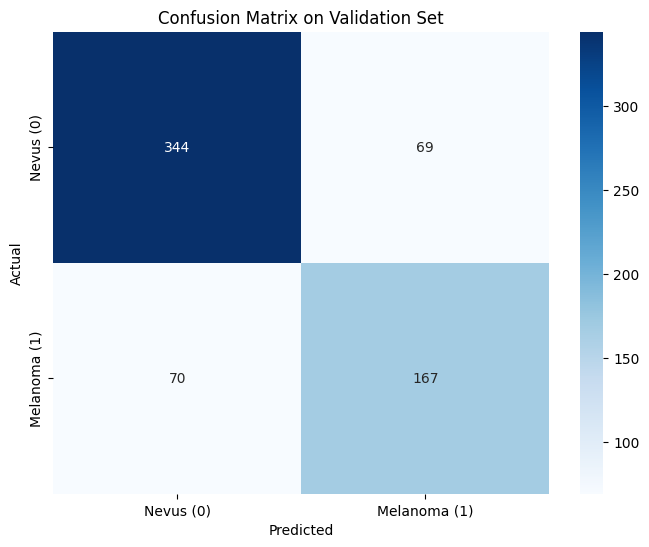

ROC AUC Score (calculated from predictions): 0.8675


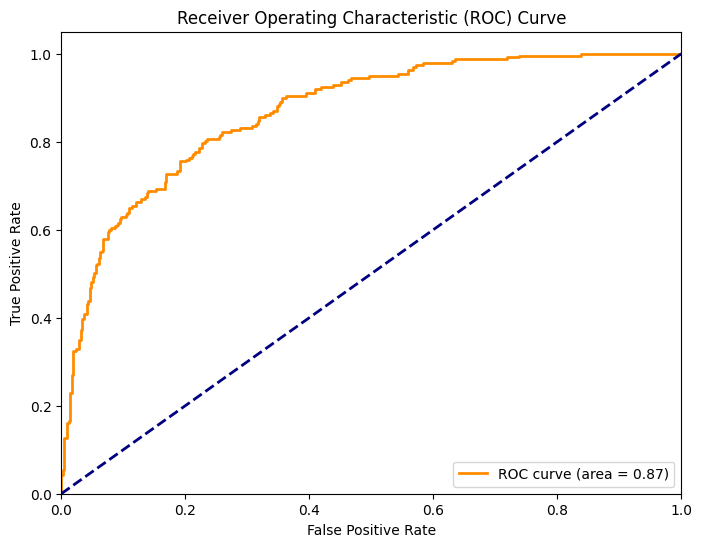

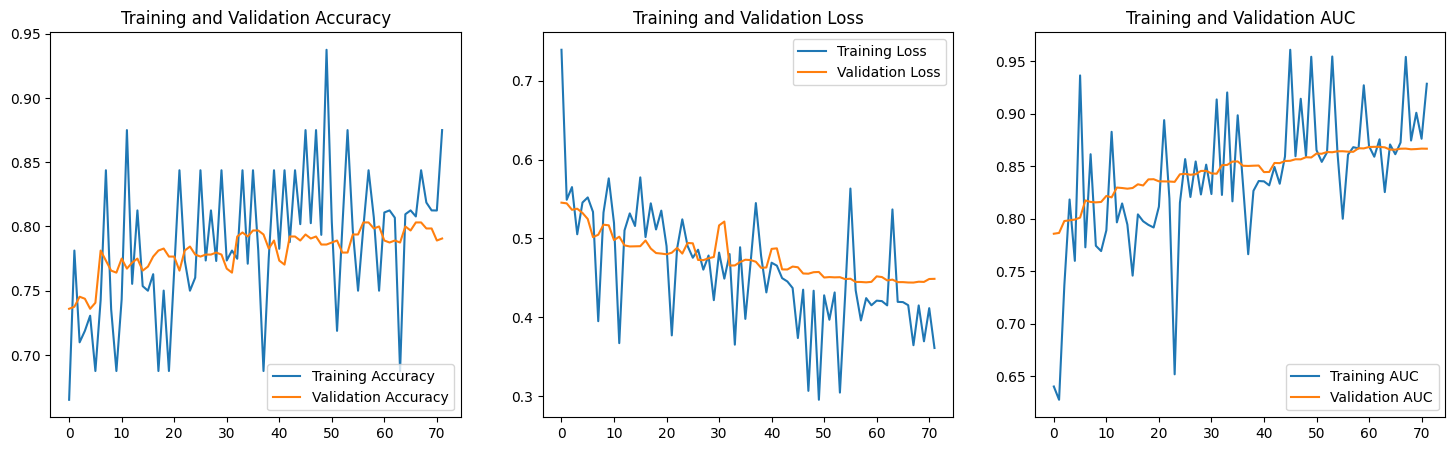

Script finished.


In [34]:
print("\nClassification Report:")
# target_names should correspond to class_indices: 0 for Nevus, 1 for Melanoma
# train_generator.class_indices gives {'0': 0, '1': 1}
# So, class 0 is 'Nevus' and class 1 is 'Melanoma'
target_names = ['Nevus (0)', 'Melanoma (1)']
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve and AUC Score
auc_score = roc_auc_score(y_true, y_pred_proba)
print(f"ROC AUC Score (calculated from predictions): {auc_score:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history.get('auc', []) # Use .get for safety if 'auc' metric name varies
    val_auc = history.history.get('val_auc', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    if auc and val_auc:
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, auc, label='Training AUC')
        plt.plot(epochs_range, val_auc, label='Validation AUC')
        plt.legend(loc='lower right')
        plt.title('Training and Validation AUC')

    plt.show()

plot_training_history(history)

print("Script finished.")